In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
asset_type = "all"

metrics = {
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [3]:
def drop_invalid_rows(df):
    return df[~df[metric_pct_chg].isna()].reset_index(drop=True)

In [4]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

all_years = list(range(start_year, eval_end_year + 1))
train_years = list(range(start_year, eval_start_year))
eval_years = list(range(eval_start_year, eval_end_year + 1))

yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"] == year]) for year in all_years
}

cumulative_yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"].between(start_year, year)])
    for year in all_years
}

# Set up extra dataframes for evaluation
for i in range(1, years_ahead + 1):
    yearly_dataframes[f"{eval_end_year + i}"] = (
        yearly_dataframes[f"{eval_end_year}"][["area", "area_code", "asset_type"]]
        .drop_duplicates()
        .assign(year=eval_end_year + i)
    )
    yearly_dataframes[f"{eval_end_year + i}"]["yearly_price_growth"] = np.nan
    yearly_dataframes[f"{eval_end_year + i}"][metric_pct_chg] = np.nan
    yearly_dataframes[f"{eval_end_year + i}"][normalized_metric_pct_chg] = np.nan


combined_eval_df = drop_invalid_rows(df[df["year"] >= eval_start_year])

# Finally
df = df.fillna(0)

In [5]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    # "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [6]:
BATCH_SIZE = 256

In [7]:
yearly_datasets = {
    f"{year}": JapanRETimeSeriesDataset(
        df,
        cumulative_yearly_dataframes[f"{year}"],
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        weight_column="weight",
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for year in all_years
}

yearly_dataloaders = {
    f"{year}": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
    )
    for year, train_dataset in yearly_datasets.items()
}

combined_eval_dataset = JapanRETimeSeriesDataset(
    df,
    combined_eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)

combined_eval_dataloader = DataLoader(
    combined_eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [9]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0


In [10]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs_per_year = 10

In [11]:
# Incremental training and evaluation (Eval years = [2021, 2022])
progress_bar = None
save_predictions = True

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

for year in all_years:
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    model = TimeSeriesTransformerModel(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        dropout=dropout,
        enc_dropout=enc_dropout,
        device=device,
    )
    model = model.to(device)

    train_dataloader = yearly_dataloaders[f"{year}"]
    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )
        train_losses.append(train_loss)
        train_r2_scores.append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weighted(
            model, combined_eval_dataloader, device=device
        )
        eval_losses.append(eval_loss)
        eval_r2_scores.append(eval_r2_score)

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")
        # 2021 and 2022 years will have overlap, so ignore those
    
    if save_predictions:
        # Even predicts for 2023 and 2024
        # Predict returns n years ahead
        output_dataset_name = f"{dataset_name}_{year + years_ahead}"
        model_output_data_path = model_output_data_paths[output_dataset_name]
        prediction_df = yearly_dataframes[f"{year + years_ahead}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            feature_columns,
            device=device,
        )

        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                "yearly_price_growth",
                metric_pct_chg,
                normalized_metric_pct_chg,
            ]
        ].to_csv(model_output_data_path, index=False)

-----------------
 Year: 2007
-----------------
 Epoch: 0
 Train Loss: 9.0614, Eval Loss: 14.8587
 Train R^2: -0.0532, Eval R^2: -0.8417
 Epoch: 1
 Train Loss: 16.4473, Eval Loss: 9.0063
 Train R^2: -0.8252, Eval R^2: -0.1876
 Epoch: 2
 Train Loss: 9.8714, Eval Loss: 7.3910
 Train R^2: -0.1898, Eval R^2: 0.0028
 Epoch: 3
 Train Loss: 7.8704, Eval Loss: 8.3999
 Train R^2: 0.0454, Eval R^2: -0.1007
 Epoch: 4
 Train Loss: 9.3950, Eval Loss: 8.8640
 Train R^2: -0.0780, Eval R^2: -0.1514
 Epoch: 5
 Train Loss: 10.2601, Eval Loss: 8.5107
 Train R^2: -0.1555, Eval R^2: -0.1150
 Epoch: 6
 Train Loss: 9.2073, Eval Loss: 8.0088
 Train R^2: -0.0677, Eval R^2: -0.0622
 Epoch: 7
 Train Loss: 8.5663, Eval Loss: 7.6521
 Train R^2: -0.0004, Eval R^2: -0.0247
 Epoch: 8
 Train Loss: 8.2519, Eval Loss: 7.4737
 Train R^2: 0.0219, Eval R^2: -0.0060
 Epoch: 9
 Train Loss: 7.7552, Eval Loss: 7.4105
 Train R^2: 0.0618, Eval R^2: 0.0006
-----------------
 Year: 2008
-----------------
 Epoch: 0
 Train Loss: 10.

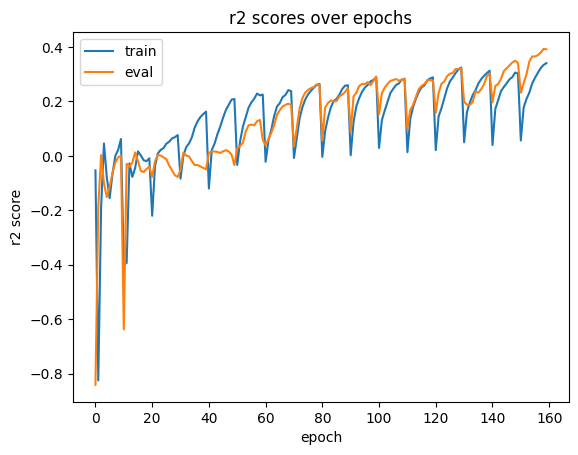

In [15]:
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

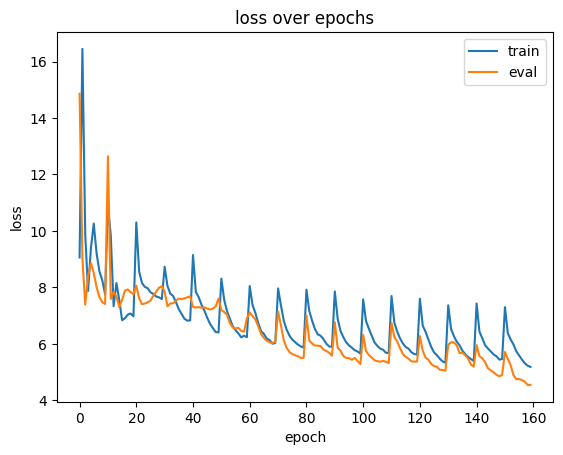

In [16]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

In [ ]:
# When I'm predicting 2022, I want a model trained only on 2020 and before
